In [30]:
import numpy as np
import sys

class NeuralNetMLP(object):
   
    """入力
       n_hidden:隠れユニットの数
       l2:正規化パラメータλ(L2が0のときは正規化なし)
        epochs:学習回数
       eta:学習率
       shuffle:循環を避けるための変数(boolでtrueのときトレーニングデータをシャッフル)
       minibatch_size:ミニバッチ当たりのトレーニングサンプルの個数
       seed:重みとシャッフルを初期化するための乱数シード
        """ 

    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    ###################################
    ######outputでえらぶニューロン#####
    ##################################
    def _onehot(self, y, n_classes):
        """ラベルをone-hot表現にエンコード
        入力
            y:目的変数の値（shape=(n_classes, n_labels)）
        出力     
        onehot 
        """   
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):#int型に変換
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """フォワードプロパゲーションのステップを計算"""

        # step 1: 隠れ層の入力     
        z_h = np.dot(X, self.w_h) + self.b_h

        # step 2: 隠れ層の活性化関数
        a_h = self._sigmoid(z_h)

        # step 3: 出力層の総入力
        z_out = np.dot(a_h, self.w_out) + self.b_out

        # step 4: 出力層の活性化関数
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """コスト関数
        
        パラメータ
        ----------
        y_enc : one-hot表現にエンコードされたクラスラベル
        output : 出力層の活性化関数(フォワードプロパゲーション)

       返り値
        ---------
        cost :正規化されたコスト
        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))
        
        ####ロジスティック関数のコスト関数#####
        ######対数尤度関数#自然対数を最小化するほうが簡単#######
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
              
        return cost
    
    ########クラスラベル予測###########
    def predict(self, X):
        """
      　入力
        -----------
        X :元の特徴量が設定された入力層
        
       出力
        ----------
        y_pred :予測されたクラスラベル
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)#出力層で一番大きい値をとるものを予測に適応
        return y_pred
    
    #########重みの学習##########
    def fit(self, X_train, y_train):
        ", X_valid, y_valid):"
        """
        入力
        -----------
        X_train : 元の特徴量が設定された入力層
        y_train :目的値のクラスラベル
        X_valid :トレーニング時の検証に使用するサンプル特徴量
        y_valid : トレーニング時の検証に使用するサンプルラベル

        出力
        ----------
        self
        """
        n_output = np.unique(y_train).shape[0]  # クラスラベルの個数が出力の数
        n_features = X_train.shape[1]

        ########################
        ######重みの初期化######
        ########################

        # 入力層→隠れ層の重み
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,size=(n_features, self.n_hidden))

        # 隠れ層→出力層の重み
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,size=(self.n_hidden, n_output))
        """
        epoch_strlen = len(str(self.epochs))  # 書式設定#表示するもの
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        """
        y_train_enc = self._onehot(y_train, n_output)#y_train:目的変数の値, n_output:クラスラベルの個数
        
        # エポック数だけトレーニングを繰り返す
        for i in range(self.epochs):

            #インデックス
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
                
            #ミニバッチの反復処理(イテレーション)
            for start_idx in range(0, indices.shape[0] - self.minibatch_size +1, 
                                   self.minibatch_size):
                #ミニバッチ学習の範囲の移動
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                ##################################
                ### フォワードプロパゲーション###
                #################################
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##############################
                ### バックプロパゲーション###
                #############################
                
                ####誤差行列(コスト関数の微分)####
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                ####シグモイド関数の微分#####
                # [n_classlabels, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                ####誤差行列(コスト関数の入力z微分)#####
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                
                #####偏微分係数(コスト関数の重みw微分)##########
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                #####偏微分係数(コスト関数の重みw微分)##########
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # 正則化
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # バイアスは正則化しない
                
                #####接続重み修正########勾配に対して反対方向
                self.w_h -= self.eta * delta_w_h
                #######バイアス修正######
                self.b_h -= self.eta * delta_b_h

                # 正則化
                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  #バイアスは正則化しない
                
                #####接続重み修正########
                self.w_out -= self.eta * delta_w_out
                #######バイアス修正######
                self.b_out -= self.eta * delta_b_out

            """
            ##############
            #### 評価 ####
            ##############
            #学習中のそれぞれのエポックごとに評価を行う
            #入力1つずつに対して
            z_h, a_h, z_out, a_out = self._forward(X_train)
            #コスト関数
            cost = self._compute_cost(y_enc = y_train_enc, output = a_out)

            y_train_pred = self.predict(X_train)#trainingデータの予測
            y_valid_pred = self.predict(X_valid)#testデータの予測
            
            #トレーニングの正解率
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            #検証の正解率
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            """

        return self

In [31]:

nn = NeuralNetMLP(n_hidden = 100, #隠れユニットの数
                 l2 = 0.01,#正則化のλパラメータ
                 epochs = 50, #n_epochs, #トレーニング回数
                 eta = 0.0005, #学習率
                 minibatch_size = 1, 
                 shuffle = True, #各エポックでデータをシャッフルするかどうか
                 seed = 1)

In [32]:
import numpy as np
import pandas as pd

######################################################
############## ランダムウォークの学習 ################
######################################################

#ランダムウォークのデータ
df_sensor = pd.read_csv('sensor_data.csv')
#train_data
X_sensor = np.array(df_sensor.loc[:,'front':'behind'])

#各行の最小センサ値の列名
minimum_kind = df_sensor.loc[:,'front':'behind'].idxmin(axis = 1)

#前の行の値との差
diff = np.array(df_sensor.loc[:,'front':'behind'].diff())
length = len(df_sensor)

#教師の初期化
teacher = np.array(np.zeros(length))
i = 1
for i in range(length):
    
    if minimum_kind[i] == 'front':
        minimum_num = 0
    elif minimum_kind[i] == 'behind':
        minimum_num = 1
        
    #最小センサ値をとるセンサが大きくなるように評価する   
    #前の行との差が正->その方向が正解
    if diff[i][minimum_num] > 0:
        teacher[i] = df_sensor.loc[i,'action']
    #前の行との差が負->逆方向が正解
    elif diff[i][minimum_num] <= 0:
        teacher[i] = -df_sensor.loc[i,'action']
    #elif diff[i][minimum_num] is None:
        #teacher[i] is None
            
    df_sensor.loc[i,'teacher'] = [teacher[i]]  

    if teacher[i] == 1:
        teacher[i] = 1
    elif teacher[i] == -1:
        teacher[i] = 0

diff = np.delete(diff, 0,0)#1行目は使わない
X_sensor = np.delete(X_sensor, 0,0)
teacher =np.delete(teacher, 0,0) #teacher =np.array([ int(x) for x in teacher if x ])#is not None
print(X_sensor)
print(teacher)
################## 学習 ######################
fit = nn.fit(X_train = X_sensor,#センサ値の差
      y_train = teacher)#前か後ろか

#################### 予測 ####################
pre = nn.predict(X_sensor)
print(pre)

[[2.9660e+01 1.0150e+02]
 [1.4410e+01 8.9000e+01]
 [2.8710e+01 7.4050e+01]
 [4.3070e+01 6.0000e+01]
 [5.6260e+01 4.5790e+01]
 [7.1470e+01 3.2520e+01]
 [8.6090e+01 4.5670e+01]
 [6.9530e+01 6.1030e+01]
 [5.4360e+01 6.2530e+01]
 [3.7400e+01 9.8030e+01]
 [2.6780e+01 9.6220e+01]
 [3.6600e+01 8.5880e+01]
 [2.6480e+01 9.5970e+01]
 [1.6450e+01 1.0302e+02]
 [2.6160e+01 9.6070e+01]
 [3.5910e+01 1.3552e+02]
 [2.5740e+01 1.4417e+02]
 [1.6070e+01 1.0517e+02]
 [2.5950e+01 1.0543e+02]
 [3.5260e+01 8.7910e+01]
 [2.4860e+01 1.0343e+02]
 [3.5160e+01 8.7160e+01]
 [2.4720e+01 9.8120e+01]
 [1.4720e+01 1.1552e+02]
 [5.2800e+00 1.2150e+02]
 [4.7600e+00 1.2057e+02]
 [4.5900e+00 1.2076e+02]
 [3.9330e+01 8.3570e+01]
 [4.7290e+01 7.3170e+01]
 [3.9070e+01 9.7120e+01]
 [6.7170e+01 4.0265e+03]
 [3.9410e+01 8.2280e+01]
 [4.6830e+01 7.5290e+01]
 [3.9380e+01 9.3520e+01]
 [4.6930e+01 1.5505e+02]
 [4.1670e+01 9.6600e+01]
 [3.0530e+01 9.9480e+01]
 [2.1520e+01 1.0791e+02]
 [1.3930e+01 1.1572e+02]
 [6.3300e+00 1.2948e+02]


In [33]:
import numpy as np
import serial

l = 1
sensor_list_append = np.array([])
teacher_append =  np.array([])
sensor_epoch  = 5
for l in range(sensor_epoch):
    print(l)
    ################### センサー値取得 ####################
    # COMポート(Arduino接続)
    ser_sensor = serial.Serial('COM4',9600)#センサー
    ser_sensor.write(b"r")#センサ読み込む

    input_num = 2 
    sensor = np.zeros((1,input_num))
    for i in range(input_num):

        #シリアル通信で受け取った情報（文字列）を改行コードがくるまで代入
        data = ser_sensor.readline().rstrip() # readline:行終端まで読み込む  rstrip:行終端コード削除　→　# \nまで読み込む(\nは削除
        data = data.decode() #対話型だとこれが必要。その情報をデコードする。

        sensor[0,i] = data

    sensor_list = np.array(sensor)
    ser_sensor.close()

    ################### 予測 #######################

    print("sensor_list : "+str(sensor_list))
    pre = nn.predict(sensor_list)
    #print(pre)

    #################### 移動 #######################
    ser_motor = serial.Serial("COM3",9600)

    #予測した値をロボットに送る
    if pre == 1:
        ser_motor.write(b"1")
    elif pre == 0:
        ser_motor.write(b"0")#バイト型で送信

    data = ser_motor.readline().rstrip()
    data = data.decode()
    #print(data)
    
    ser_motor.close()
    
    ###############################################
    ################## 逐次学習 ###################
    ###############################################

    ############## センサー値取得 #################
    next_ser_sensor = serial.Serial('COM4',9600)
    next_ser_sensor.write(b"r")#センサ読み込む

    next_sensor_list = np.zeros((1,input_num))

    for i in range(input_num):

        data = next_ser_sensor.readline().rstrip()
        data = data.decode()
        next_sensor_list[0,i] = data

    next_sensor_list = np.array(next_sensor_list)
    #print(next_sensor_list)
    next_ser_sensor.close()

    #2つのセンサ値のうち小さいほう
    minimum_kind = np.argmin(sensor_list)
    #print("minimum_num:"+str(minimum_kind))

    #教師の初期化
    t_teacher = np.array(np.zeros(1))

    if pre == 1:
        t_teacher[0] = 1
    elif pre == 0:
        t_teacher[0] = -1

    #前の行との差が正->その方向が正解
    if next_sensor_list[0,minimum_kind] - sensor_list[0,minimum_kind] > 0:
        t_teacher[0] = t_teacher[0]
    #前の行との差が負->逆方向が正解
    elif next_sensor_list[0,minimum_kind] - sensor_list[0,minimum_kind] <= 0:
        t_teacher[0] = -t_teacher[0]

    if t_teacher[0] == 1:
        t_teacher[0] = 1
    elif t_teacher[0] == -1:
        t_teacher[0] = 0

    t_teacher = np.array(t_teacher)

    #sensor_listをl次元の配列に順次追加していく
    sensor_list_append = np.append(sensor_list_append, sensor_list).reshape(l+1, 2)#, axis= 1)
    #動きをl次元の配列に順次追加していく
    teacher_append = np.append(teacher_append, t_teacher)#, axis= 1)
    print(sensor_list_append)
    print(teacher_append)
    
    X_train = np.append(X_sensor, sensor_list_append, axis= 0)
    y_train = np.append(teacher, teacher_append, axis= 0)
    
    #学習
    fit = nn.fit(X_train  ,y_train)
    #fit = nn.fit(X_train = sensor_list ,y_train = t_teacher)#前か後ろか
    #print(predict)

0
sensor_list : [[5.000e-02 6.898e+01]]
[[5.000e-02 6.898e+01]]
[0.]
1
sensor_list : [[5.000e-02 5.888e+01]]
[[5.000e-02 6.898e+01]
 [5.000e-02 5.888e+01]]
[0. 0.]
2
sensor_list : [[69.1  51.05]]
[[5.000e-02 6.898e+01]
 [5.000e-02 5.888e+01]
 [6.910e+01 5.105e+01]]
[0. 0. 1.]
3
sensor_list : [[59.43 61.1 ]]
[[5.000e-02 6.898e+01]
 [5.000e-02 5.888e+01]
 [6.910e+01 5.105e+01]
 [5.943e+01 6.110e+01]]
[0. 0. 1. 0.]
4
sensor_list : [[68.9  52.22]]
[[5.000e-02 6.898e+01]
 [5.000e-02 5.888e+01]
 [6.910e+01 5.105e+01]
 [5.943e+01 6.110e+01]
 [6.890e+01 5.222e+01]]
[0. 0. 1. 0. 1.]


In [34]:
import csv
#sensorとteacherを記録するためのcsvファイルを開く
with open('learning_data.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['front', 'behind','action'])

#ランダムウォークと逐次のデータ記録
for l in range( length+ sensor_epoch -1):
    
    #csvファイルにBMUとそのクラスを追記
    with open('learning_data.csv', 'a') as f: 
        writer = csv.writer(f)
        writer.writerow([X_train[l, 0],X_train[l, 1],y_train[l]])
            

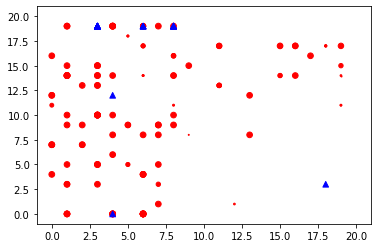

In [35]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import csv
df = pd.read_csv('learning_data.csv')
N = 20#linear size of 2D map
n_teacher = len(df) #教師データの数(学習回数)#行数
np.random.seed(1000)#シード (種) を指定することで、発生する乱数をあらかじめ固定
dimension = 2#ベクトルの次元
i = 0
def main():
    #初期ノード
    # N x N ×dimension の配列の乱数
    nodes = np.random.rand(N, N, dimension)#0.0~1.0の値で一様分布

    for x in range (N):
        for y in range(N):
            for z in range(dimension):
                M = df.iloc[:,z].max()
                m = df.iloc[:,z].min()
                nodes[x, y, z] = 0.5 *(M - m) * nodes[x, y, z] + m
    
    #BMUとクラスを記録するためのcsvファイルを開く
    with open('bmu.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['index','bmu','classnum'])
        
    ax = plt.subplot()
    for df3 in range(2):
        df3 = pd.read_csv('learning_data.csv')
        
        for i in range(n_teacher):#150回
            #教師信号
            teachers = np.array(df.loc[i,'front':'behind'].values) #X 
            train(nodes, teachers)
            bmu = best_matching_unit(nodes, teachers)
            y = np.array(df.loc[:, ['action']].values)
            
            #csvファイルにBMUとそのクラスを追記
            with open('bmu.csv', 'a') as f: 
                writer = csv.writer(f)
                writer.writerow([i,bmu,y[i]])
            
            df2 = pd.read_csv('bmu.csv')
            if y[i] != df2['classnum'].any:
                if y[i]==[0]:#setosa
                    col='red'
                    mark = 'o'

                elif y[i]==[1]:#versicolor
                    col='blue'
                    mark = '^'
            
            scale = 1 * df2['bmu'].value_counts()
            ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale, alpha = 1.0)
            
    for i in range(n_teacher):
        
        if y[i] == df2['classnum'].any:
            col = 'black'
            mark = 'x'
            scale = 10
            ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale)
            
    plt.xlim(0-1,N+1)
    plt.ylim(0-1,N+1)
    plt.show()
    
#学習   
def train(nodes, teachers):
    
    bmu = best_matching_unit(nodes, teachers)#BMU:データに対し最も似ているベクトルを持つユニットあとで定義

    for x in range(N):
        for y in range(N):
            c = np.array([x,y])
            d = np.linalg.norm(c - bmu)#ユニットの位置とBMUとの距離
            L = learning_ratio(i)#学習時間を決定するパラメータ#iはe^(-t/λ)
            S = learning_radius(i, d)#更新するユニットがどの程度BMUの近傍にいるのかを表現
            for z in range(dimension):
                nodes[x, y, z] += L * S * (teachers[z] - nodes[x, y, z])#zはがくの長さなど

                
def best_matching_unit(nodes, teacher):
    norms = np.zeros((N,N))# N×Nの２次元配列を生成
    for x in range (N):
        for y in range(N):
            for z in range(dimension):
                norms[x, y] += (nodes[x,y,z] - teacher[z])**2
    
    bmu_1 = np.argmin(norms)#１次元配列で考えたとき何番目かを返す
    bmu = np.unravel_index(bmu_1,(N,N))#argminと組み合わせることで,もとの行列の何行何列目に最小値があるのかわかる

    return bmu 

def neighbourhood(t):
    halflife = float(n_teacher/4)#時定数
    initial = float(N/4)
    return initial*np.exp(-t/halflife)

def learning_ratio(t):
    halflife=float(n_teacher/4)#時定数
    initial=0.1#Lの初期値
    return initial*np.exp(-t/halflife)

def learning_radius(t, d):
    s=neighbourhood(t)
    return np.exp(-d**2/(2*s**2))

main()